## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

##### Ver. 4.0: 01-May-2023

In [25]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import gc

from utilities import plot_learning_curve, two_axes_plot
from reinforce_classes import PolicyNetwork, Agent

In [29]:
# Milling operation constants
WEAR_THRESHOLD = 3.0 # mm
WEAR_THRESHOLD_NORMALIZED = 1.0 # normalized to the max wear threshold
MILLING_OPERATIONS_MAX = 400
BREAKDOWN_CHANCE = 0.05

# Policy network learning parameters
gamma = 0.99
alpha = 0.01
EPISODES = 300 # Train for N episodes
PREFIX = 'Tool_Wear_Env_2_01-May-2023_'

Tool wear data imported (121 records). WEAR_THRESHOLD_NORMALIZED: 0.168


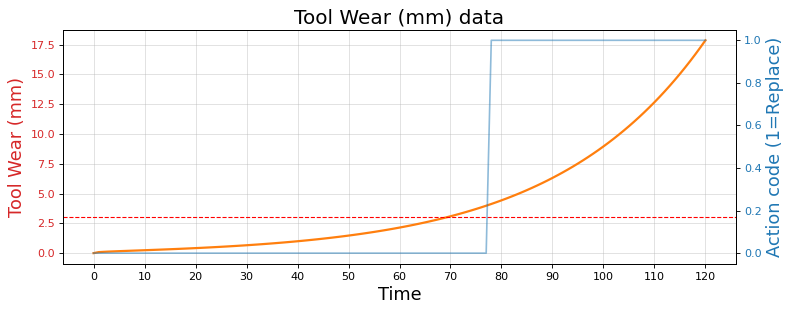

In [30]:
## Read data
df = pd.read_csv('Tool_Wear_VB.csv')
df = df[['time', 'VB_mm', 'ACTION_CODE']]

# Normalizing entire df with min-max scaling
WEAR_MIN = df['VB_mm'].min() 
WEAR_MAX = df['VB_mm'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')

## Visualize the data
n_records = len(df.index)
x = df['time'].values.tolist()
y1 = df['VB_mm'].values.tolist()
y2 = df['ACTION_CODE'].values.tolist()

two_axes_plot(x, y1, y2, title='Tool Wear (mm) data', \
              x_label='Time', y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', \
              xticks=10,threshold=WEAR_THRESHOLD)

### Environment class - Milling Tool Wear "environment"
- Simple actions: Replace / do-not-replace
- Reward for every step of lengthened life
- Reward for every step where wear < Threshold
- Penalty (cost) for replacement
- Termination condition:
    - Wear > Threshold
    - End of Wear data-frame
    - Episode length >1000


In [31]:
#-----------------------------------------------------------------------------------------------------------------
# Milling Tool wear environment 
# Author: Rajesh Siraskar
# Date: 28-Apr-2023
# V 2.0: Open AI Gym compliant. Fix threshold normalization bug. Potential reward function errors
# V 3.0 Modify reward function and simpify to basics
# V 4.0 Convert Pandas dataframe to numpy array
#-----------------------------------------------------------------------------------------------------------------

class MillingTool_V1(gym.Env):
    """Custom Milling Tool Wear Environment that follows the Open AI gym interface."""

    metadata = {"render.modes": ["human"]}
    
    def __init__(self, df, wear_threshold, max_operations):        

        # Machine data frame properties    
        self.df = df
        self.df_length = len(self.df.index)
        self.df_index = 0
        
        # Milling operation and tool parameters 
        self.wear_threshold = wear_threshold
        self.max_operations = max_operations
        self.reward = 0.0

        # Statistics
        self.ep_length = 0
        self.ep_total_reward = 0
        self.ep_tool_replaced = 0
        self.ep_rewards_history = []
        self.ep_length_history = []
        self.ep_tool_replaced_history = []
        
        ## Gym interface Obsercation and Action spaces
        # All features are normalized [0, 1]
        self.min_feature = 0.0
        self.max_feature = 1.0
        
        # Define state and action limits        
        self.low_state = np.array([self.min_feature, self.min_feature], dtype=np.float32)
        self.high_state = np.array([self.max_feature, self.max_feature], dtype=np.float32)
        
        # Observation and action spaces
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=self.low_state, high=self.high_state, dtype=np.float32)
             
    def step(self, action):
        """
        Args: action. Discrete - 1=Replace tool, 0=Continue milling operation
        Returns: next_state, reward, terminated, truncated , info
        """
        # Termination condition
        if self.ep_length > self.max_operations:
            terminated = True
            info = {'termination':'Max. milling operations crossed.'}
        else:
            terminated = False
            info = {'action':'Continue'} 
        
            # Get current observation from environment
            self.state = self._get_observation(self.df_index)
            time_step = self.state[0]
            wear = self.state[1]

            ## Reward function:
            # +ve Rewards:
            #  1. Each time-step survived: +4.0 (milling operation lengthened)
            #  2. Tool wear < Threshold: +1.0
            # -ve Penalties:
            #  3. Above threshold: -2.0
            #  4. Tool replaced: -10.0
            # Termination:
            #  1. Time-steps (operations) > 1000
            #  2. Data-frame end

            reward = 0.0
            if wear < self.wear_threshold:
                reward += self.df_index
            else:
                # Threshold breached
                reward += -self.df_index # farther away from threshold => more penalty

            # Based on the action = 1 replace the tool or if 0, continue with normal operation
            if action:
                reward += -100.0
                # We replace the tool - so roll back tool life. -1 so that the increment in df_index will reset it to 0
                self.df_index = -1
                self.ep_tool_replaced += 1
                info = {'action':'Tool replaced'}

            # Increment reward for the episode based on final evaluation of reward of this step
            self.reward += float(reward/1e3)
            self.ep_total_reward += self.reward

            # Post process of step: Get next observation, fill history arrays
            self.ep_length += 1
            
            if self.df_index > (self.df_length-2):
                self.df_index = -1
                info = {'data_index':'Data over'}

            # We can now read the next state, for agent's policy to predict the "Action"
            self.df_index += 1
            state_ = self._get_observation(self.df_index)
        return state_, self.reward, terminated, info

    def _get_observation(self, index):
        next_state = np.array([
            self.df['time'][index],
            self.df['VB_mm'][index]
        ], dtype=np.float32)
                
        return next_state

    def reset(self):
        # Append Episode stats. before resetting variables
        self.ep_rewards_history.append(self.ep_total_reward)
        self.ep_length_history.append(self.ep_length)
        self.ep_tool_replaced_history.append(self.ep_tool_replaced)
        
        # Reset environment variables and stats.
        self.df_index = 0
        self.reward = 0.0
        self.ep_total_reward = 0
        self.ep_tool_replaced = 0
        self.ep_length = 0

        # Get the new state
        self.state = self._get_observation(self.df_index)
        terminated = False
        return np.array(self.state, dtype=np.float32)
    
    def render(self, mode='human', close=False):
        print(f'{self.df_index:>3d} | Ep.Len.: {self.ep_length:>3d} | Reward: {self.reward:>10.4f} | Wear: {wear:>5.4f} | {info}')
        
    def close(self):
        del [self.df]
        gc.collect()
        print('** -- Envoronment closed. Data-frame memory released. Garbage collector invoked successfully -- **')


In [33]:
## V2: Add realistic situations 
## 1. Random tool breakdown after crossing 30% of wear threshold
## 2. Random white noise added to wear

class MillingTool_V2(gym.Env):
    """Custom Milling Tool Wear Environment that follows the Open AI gym interface."""

    metadata = {"render.modes": ["human"]}
    
    def __init__(self, df, wear_threshold, max_operations, breakdown_chance):        

        # Machine data frame properties    
        self.df = df
        self.df_length = len(self.df.index)
        self.df_index = 0
        
        # Milling operation and tool parameters 
        self.wear_threshold = wear_threshold
        self.max_operations = max_operations
        self.breakdown_chance = breakdown_chance
        self.reward = 0.0

        # Statistics
        self.ep_length = 0
        self.ep_total_reward = 0
        self.ep_tool_replaced = 0
        self.ep_rewards_history = []
        self.ep_length_history = []
        self.ep_tool_replaced_history = []
        
        ## Gym interface Obsercation and Action spaces
        # All features are normalized [0, 1]
        self.min_feature = 0.0
        self.max_feature = 1.0
        
        # Define state and action limits        
        self.low_state = np.array([self.min_feature, self.min_feature], dtype=np.float32)
        self.high_state = np.array([self.max_feature, self.max_feature], dtype=np.float32)
        
        # Observation and action spaces
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=self.low_state, high=self.high_state, dtype=np.float32)
             
    def step(self, action):
        """
        Args: action. Discrete - 1=Replace tool, 0=Continue milling operation
        Returns: next_state, reward, terminated, truncated , info
        """
        # Get current observation from environment
        self.state = self._get_observation(self.df_index)
        time_step = self.state[0]
        wear = self.state[1]
        
        # Add white noise for robustness
        wear += np.random.rand()/1e3
        
        # Termination condition
        if self.ep_length > self.max_operations:
            terminated = True
            self.reward = 0.0
            self.df_index = -1
            info = {'termination':'Max. milling operations crossed'}
            
        elif wear > self.wear_threshold and np.random.uniform() < self.breakdown_chance:
            terminated = True
            self.reward = 0.0
            self.df_index = -1
            info = {'termination':'Tool breakdown'}
            
        else:
            terminated = False
            info = {'action':'Continue'} 

            reward = 0.0
            if wear < self.wear_threshold:
                reward += self.df_index
            else:
                # Threshold breached
                reward += -self.df_index # farther away from threshold => more penalty

            # Based on the action = 1 replace the tool or if 0, continue with normal operation
            if action:
                reward += -100.0
                # We replace the tool - so roll back tool life. -1 so that the increment in df_index will reset it to 0
                self.df_index = -1
                self.ep_tool_replaced += 1
                info = {'action':'Tool replaced'}

            # Increment reward for the episode based on final evaluation of reward of this step
            self.reward += float(reward/1e3)
            self.ep_total_reward += self.reward

            # Post process of step: Get next observation, fill history arrays
            self.ep_length += 1
            
            if self.df_index > (self.df_length-2):
                self.df_index = -1
                info = {'data_index':'Data over'}

        # We can now read the next state, for agent's policy to predict the "Action"
        self.df_index += 1
        state_ = self._get_observation(self.df_index)

        return state_, self.reward, terminated, info

    def _get_observation(self, index):
        next_state = np.array([
            self.df['time'][index],
            self.df['VB_mm'][index]
        ], dtype=np.float32)
                
        return next_state

    def reset(self):
        # Append Episode stats. before resetting variables
        self.ep_rewards_history.append(self.ep_total_reward)
        self.ep_length_history.append(self.ep_length)
        self.ep_tool_replaced_history.append(self.ep_tool_replaced)
        
        # Reset environment variables and stats.
        self.df_index = 0
        self.reward = 0.0
        self.ep_total_reward = 0
        self.ep_tool_replaced = 0
        self.ep_length = 0

        # Get the new state
        self.state = self._get_observation(self.df_index)
        terminated = False
        return np.array(self.state, dtype=np.float32)
    
    def render(self, mode='human', close=False):
        print(f'{self.df_index:>3d} | Ep.Len.: {self.ep_length:>3d} | Reward: {self.reward:>10.4f} | Wear: {wear:>5.4f} | {info}')
        
    def close(self):
        del [self.df]
        gc.collect()
        print('** -- Envoronment closed. Data-frame memory released. Garbage collector invoked successfully -- **')

In [34]:
EPISODES = 600
### Main loop
rewards_history = []
loss_history = []

env = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, BREAKDOWN_CHANCE)
# env = MillingTool_V1(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX)

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()
    
    # Sample a trajectory
    for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        agent.rewards.append(reward)
        #env.render()
        if done:
            break
            
    # Learn during this episode 
    loss = agent.learn() # train per episode
    total_reward = sum(agent.rewards)
    
    # Record statistics for this episode
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting
    # episode_length_history.append(env.ep_length)
    # tool_replaced_history.append(env.ep_tool_replaced)
    
    # On-policy - so discard all data 
    agent.onpolicy_reset()

    if (episode%100 ==0):
        print(f'[{episode:04d}] Loss: {loss:>.2e} | Reward: {total_reward:>.2e} | Ep.length: {env.ep_length:04d}')

[0000] Loss: -2.48e+05 | Reward: -4.03e+03 | Ep.length: 0400
[0100] Loss: -4.98e+04 | Reward: -7.83e+03 | Ep.length: 0400
[0200] Loss: -2.73e+05 | Reward: -4.48e+03 | Ep.length: 0400
[0300] Loss: 1.16e+04 | Reward: 6.26e+02 | Ep.length: 0400
[0400] Loss: 2.16e+02 | Reward: 6.50e+01 | Ep.length: 0082
[0500] Loss: 1.07e+04 | Reward: 1.94e+03 | Ep.length: 0400


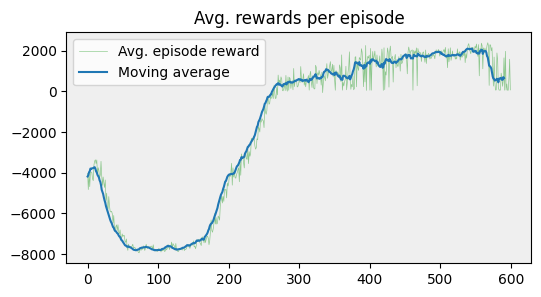

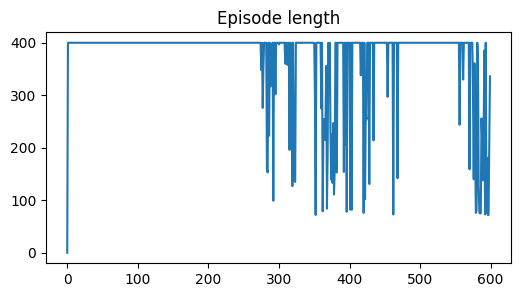

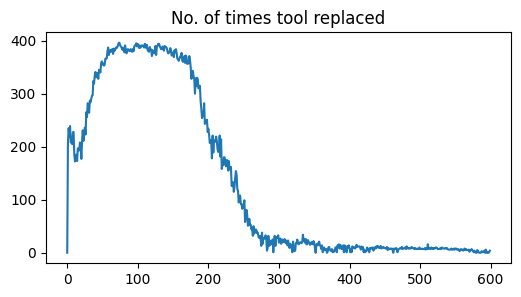

In [40]:
# filename = PREFIX + '_Rewards.png'
# x = [i+1 for i in range(EPISODES)]
# plot_learning_curve(x, rewards_history=rewards_history, loss_history=loss_history, moving_avg_n=10, filename=filename) 

plt.rcParams['figure.figsize'] = (6, 3)

ax = plt.axes()
ax.set_facecolor('#EFEFEF')

window_size = 10
# Convert error array to pandas series
ma_reward = pd.Series(rewards_history)
windows = ma_reward.rolling(window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
# Remove null entries from the list
moving_avg_lst = moving_avg_lst[window_size - 1:]

filename = PREFIX + '_Avg_rewards_per_episode.png'
plt.plot(rewards_history,  color='tab:green', alpha=0.5, linewidth=0.5)
plt.plot(moving_avg_lst, color='tab:blue')
plt.legend(['Avg. episode reward', 'Moving average'])
plt.title('Avg. rewards per episode')
plt.savefig(filename)
plt.show()

filename = PREFIX + '_Tool_Replacements.png'
plt.plot(env.ep_length_history)
plt.title('Episode length')
plt.show()
plt.plot(env.ep_tool_replaced_history)
plt.title('No. of times tool replaced')
plt.savefig(filename)
plt.show()

In [45]:
env.close()

** -- Envoronment closed. Data-frame memory released. Garbage collector invoked successfully -- **
